# Regressão Linear com NumPy

## Objetivos deste experimento

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se programação totalmente NumPy com:
- o **cálculo do gradiente**,
- a **função de perda** e
- a atualização dos parâmetros são feitos de forma explícita.
- A rede é criada com uma camada como uma classe

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

## Importação dos pacotes

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt   # para plotting

from sklearn.datasets import load_iris  # para carregar dataset

import numpy as np  # processamento matricial

np.random.seed(1234)

## Dataset

### Leitura dos dados

In [ ]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1]
y_train = data[:,1:2]

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float64
y_train.shape: (50, 1) float64
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [ ]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()

Text(0, 0.5, 'Comprimento petalas')

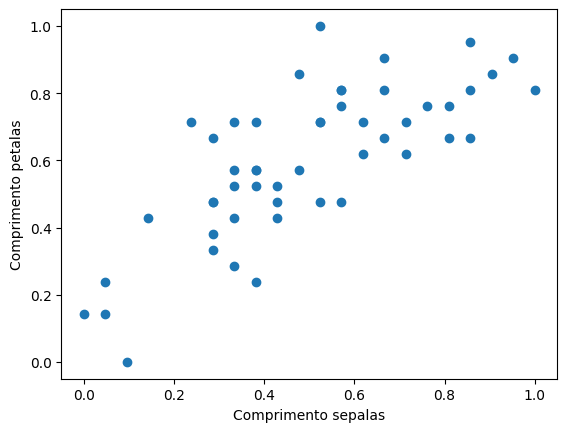

In [ ]:
plt.scatter(x_train,y_train)
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')

## Modelo da rede

### Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/linhareta.png)

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde
* $w_1$ é o coeficiente angular da reta e
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

### Linear Regression Model

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinearNeuronio.png)

### Formulação matricial do neurônio

* $\mathbf{w} = [w_0 \ w_1]$ é vetor linha de parâmetros e
* $\mathbf{x} = [1 \ x_0] $ é vetor linha de uma amostra (com *bias*).

$$ \hat{y} = 1 w_0 + x_0 w_1 $$

$$ [\hat{y}] = [1 \ x_0] \begin{bmatrix} w_0 \\ w_1 \end{bmatrix} $$

$$ \mathbf{\hat{y}} = \mathbf{x} \mathbf{w^T} $$

### Fazendo o predict de várias amostras

$$ \begin{matrix}
\begin{bmatrix}
\hat{y}_0\\
\hat{y}_1\\
\\
\hat{y}_{M-1}
\end{bmatrix} &=& \begin{bmatrix}
1 & x_0 \\
1 & x_1\\
\\
1 & x_{M-1} \\
\end{bmatrix}
&
\begin{bmatrix}
w_0\\
w_1
\end{bmatrix} \\
(M,1) & & (M,2) & (2,1) \\
\end{matrix} $$

### Preenchendo x com coluna de 1's para bias

In [ ]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [ ]:
x_train_bias

array([[1.        , 1.        ],
       [1.        , 0.71428571],
       [1.        , 0.95238095],
       [1.        , 0.28571429],
       [1.        , 0.76190476],
       [1.        , 0.38095238],
       [1.        , 0.66666667],
       [1.        , 0.        ],
       [1.        , 0.80952381],
       [1.        , 0.14285714],
       [1.        , 0.04761905],
       [1.        , 0.47619048],
       [1.        , 0.52380952],
       [1.        , 0.57142857],
       [1.        , 0.33333333],
       [1.        , 0.85714286],
       [1.        , 0.33333333],
       [1.        , 0.42857143],
       [1.        , 0.61904762],
       [1.        , 0.33333333],
       [1.        , 0.47619048],
       [1.        , 0.57142857],
       [1.        , 0.66666667],
       [1.        , 0.57142857],
       [1.        , 0.71428571],
       [1.        , 0.80952381],
       [1.        , 0.9047619 ],
       [1.        , 0.85714286],
       [1.        , 0.52380952],
       [1.        , 0.38095238],
       [1.

### Classe com o modelo da rede

In [ ]:
class Net():
    def __init__(self, n_in, n_out):
        #self.w = np.random.uniform(-0.1,0.1,(n_out,n_in)) #inicialização dos parâmetros
        self.w = np.zeros(shape=(n_out,n_in))
    def forward(self, x_bias):
        return x_bias.dot(self.w.T)

### Criando a rede, instanciando o objeto model

In [ ]:
model = Net(2,1) # duas entradas (1 + x0) e uma saída y_pred

### Testando o predict da rede (mesmo sem treiná-la)

In [ ]:
xin = np.random.randn(4,2) # 4 amostras, 2 entradas (1 + x0)
ypred = model.forward(xin)
ypred

array([[0.],
       [0.],
       [0.],
       [0.]])

## Treinamento via gradiente descendente

Função de perda:
$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$

Gradiente:
$$  \mathbf{\nabla{J_w}} = \frac{2}{M}\mathbf{x^T}(\mathbf{x w^T} - \mathbf{y}) $$

Atualização dos parâmetros pelo gradiente descendente:
$$ \mathbf{w} = \mathbf{w} − \eta (\mathbf{\nabla J_w})^T $$

### Laço de treinamento

In [ ]:
num_epochs = 100
learning_rate = 0.5
for epoch in range(num_epochs):

    # forward - predict
    y_pred = model.forward(x_train_bias)

    #loss cálculo da função de perda
    loss = np.square(y_pred - y_train).mean()

    # cálculo do gradiente pelas derivadas parciais
    w_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(model.w.T) - y_train)

    # gradiente descendente
    model.w = model.w - learning_rate * w_grad.T

    # verbose
    if (epoch+1) % 1 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss))

Epoch[1/100], loss: 0.409070
Epoch[2/100], loss: 0.055997
Epoch[3/100], loss: 0.032085
Epoch[4/100], loss: 0.029729
Epoch[5/100], loss: 0.028853
Epoch[6/100], loss: 0.028139
Epoch[7/100], loss: 0.027497
Epoch[8/100], loss: 0.026914
Epoch[9/100], loss: 0.026385
Epoch[10/100], loss: 0.025905
Epoch[11/100], loss: 0.025469
Epoch[12/100], loss: 0.025073
Epoch[13/100], loss: 0.024713
Epoch[14/100], loss: 0.024387
Epoch[15/100], loss: 0.024090
Epoch[16/100], loss: 0.023821
Epoch[17/100], loss: 0.023577
Epoch[18/100], loss: 0.023355
Epoch[19/100], loss: 0.023154
Epoch[20/100], loss: 0.022971
Epoch[21/100], loss: 0.022805
Epoch[22/100], loss: 0.022655
Epoch[23/100], loss: 0.022518
Epoch[24/100], loss: 0.022394
Epoch[25/100], loss: 0.022281
Epoch[26/100], loss: 0.022179
Epoch[27/100], loss: 0.022086
Epoch[28/100], loss: 0.022001
Epoch[29/100], loss: 0.021925
Epoch[30/100], loss: 0.021855
Epoch[31/100], loss: 0.021792
Epoch[32/100], loss: 0.021735
Epoch[33/100], loss: 0.021683
Epoch[34/100], loss

## Avaliação

### Predict

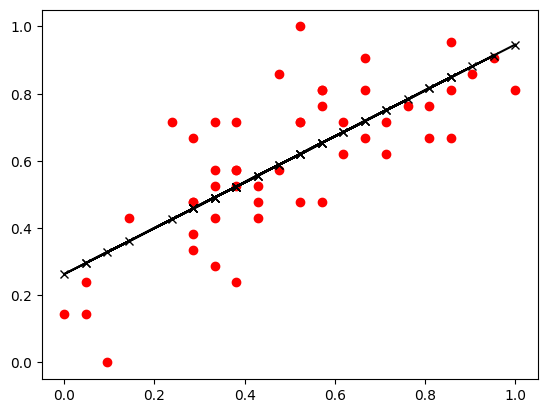

In [ ]:
y_pred = model.forward(x_train_bias)
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, y_pred, 'kx-', label='Fitting Line')

### Parâmetros treinados

In [ ]:
print(model.w)

[[0.26313715 0.68300175]]


### Avaliação do modelo

In [ ]:
loss = np.square(y_pred - y_train).mean()
loss

np.float64(0.02117014338157031)

### Valor ótimo, solução analítica

$$  \mathbf{w} =(\mathbf{x^T} \mathbf{x})^{−1}\mathbf{x^T} \mathbf{y} $$

In [ ]:
x = x_train_bias
y = y_train
w_opt = (np.linalg.inv((x.T).dot(x)).dot(x.T)).dot(y)
print(w_opt.T)

[[0.26134159 0.68646976]]


# Exercícios

## Questões

1. Quantos parâmetros são treinados nesse modelo?

R - 2 parametros W0 e W1

2. Qual é o número de atributos de entrada para a rede?

R - 1 parametro X com BIAS é 2

3. Qual é o número de saídas da rede?

R - 1 parametro Y

4. Suponha que eu tenha agora 5 mil amostras para fazer a predição. Qual é o shape da matriz de entrada?
R - [5000,2]

5 - Qual é o shape do matriz de saída?

R - [5000,1]


## Atividades

1. Modifique o laço do treinamento via gradiente descendente para guardar em uma lista, o valor da perda no final
   de cada época. Após o treinamento, plote o valor da perda em função da época.



2. Calcule o valor da perda (MSE) da rede com os parâmetros inicializados, sem serem treinados.
3. Coloque os valores dos pesos da solução ótima analítica no modelo da rede e calcule o valor da perda (MSE) e
   compare com o valor da perda obtida pelo método da otimização via gradiente descendente.

In [ ]:
# Exercicio 1

num_epochs = 100
learning_rate = 0.5
losses = []
for epoch in range(num_epochs):

    # forward - predict
    y_pred = model.forward(x_train_bias)

    #loss cálculo da função de perda
    loss = np.square(y_pred - y_train).mean()

    # cálculo do gradiente pelas derivadas parciais
    w_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(model.w.T) - y_train)

    # gradiente descendente
    model.w = model.w - learning_rate * w_grad.T

    # Inserindo a perda numa LISTA

    losses.append(loss)

    # verbose
    if (epoch+1) % 1 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss))

Epoch[1/100], loss: 0.021170
Epoch[2/100], loss: 0.021170
Epoch[3/100], loss: 0.021170
Epoch[4/100], loss: 0.021170
Epoch[5/100], loss: 0.021170
Epoch[6/100], loss: 0.021170
Epoch[7/100], loss: 0.021170
Epoch[8/100], loss: 0.021170
Epoch[9/100], loss: 0.021170
Epoch[10/100], loss: 0.021170
Epoch[11/100], loss: 0.021170
Epoch[12/100], loss: 0.021170
Epoch[13/100], loss: 0.021170
Epoch[14/100], loss: 0.021170
Epoch[15/100], loss: 0.021170
Epoch[16/100], loss: 0.021170
Epoch[17/100], loss: 0.021170
Epoch[18/100], loss: 0.021170
Epoch[19/100], loss: 0.021170
Epoch[20/100], loss: 0.021170
Epoch[21/100], loss: 0.021170
Epoch[22/100], loss: 0.021170
Epoch[23/100], loss: 0.021170
Epoch[24/100], loss: 0.021170
Epoch[25/100], loss: 0.021169
Epoch[26/100], loss: 0.021169
Epoch[27/100], loss: 0.021169
Epoch[28/100], loss: 0.021169
Epoch[29/100], loss: 0.021169
Epoch[30/100], loss: 0.021169
Epoch[31/100], loss: 0.021169
Epoch[32/100], loss: 0.021169
Epoch[33/100], loss: 0.021169
Epoch[34/100], loss

In [ ]:
# Exercicio 2

model = Net(2,1)
# forward - predict
y_pred = model.forward(x_train_bias)
print(y_pred)
#loss cálculo da função de perda
loss = np.square(y_pred - y_train).mean()
print(loss)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
0.40907029478458073


In [ ]:
# Execicio 3

num_epochs = 100
learning_rate = 0.5
losses = []
for epoch in range(num_epochs):

    # forward - predict
    y_pred = model.forward(x_train_bias)

    #loss cálculo da função de perda
    loss = np.square(y_pred - y_train).mean()

    # cálculo do gradiente pelas derivadas parciais
    w_grad = (2.0/n_samples) * (x_train_bias.T).dot(x_train_bias.dot(model.w.T) - y_train)

    # gradiente descendente
    model.w = model.w - learning_rate * w_grad.T

    # Inserindo a perda numa LISTA

    losses.append(loss)


print(f"Valores Gradiente:\n W: {model.w} | perda : {loss} ")

# Solucao Ótima

x = x_train_bias
y = y_train
w_opt = (np.linalg.inv((x.T).dot(x)).dot(x.T)).dot(y)

model.w = w_opt.T

# forward - predict
y_pred = model.forward(x_train_bias)

#loss cálculo da função de perda
loss = np.square(y_pred - y_train).mean()

print(f"Valores Ótimas:\n W: {model.w} | perda : {loss} ")


Valores Gradiente:
 W: [[0.26313715 0.68300175]] | perda : 0.021170216344029543 
Valores Ótimas:
 W: [[0.26134159 0.68646976]] | perda : 0.021169424119097165 


# Aprendizados